In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


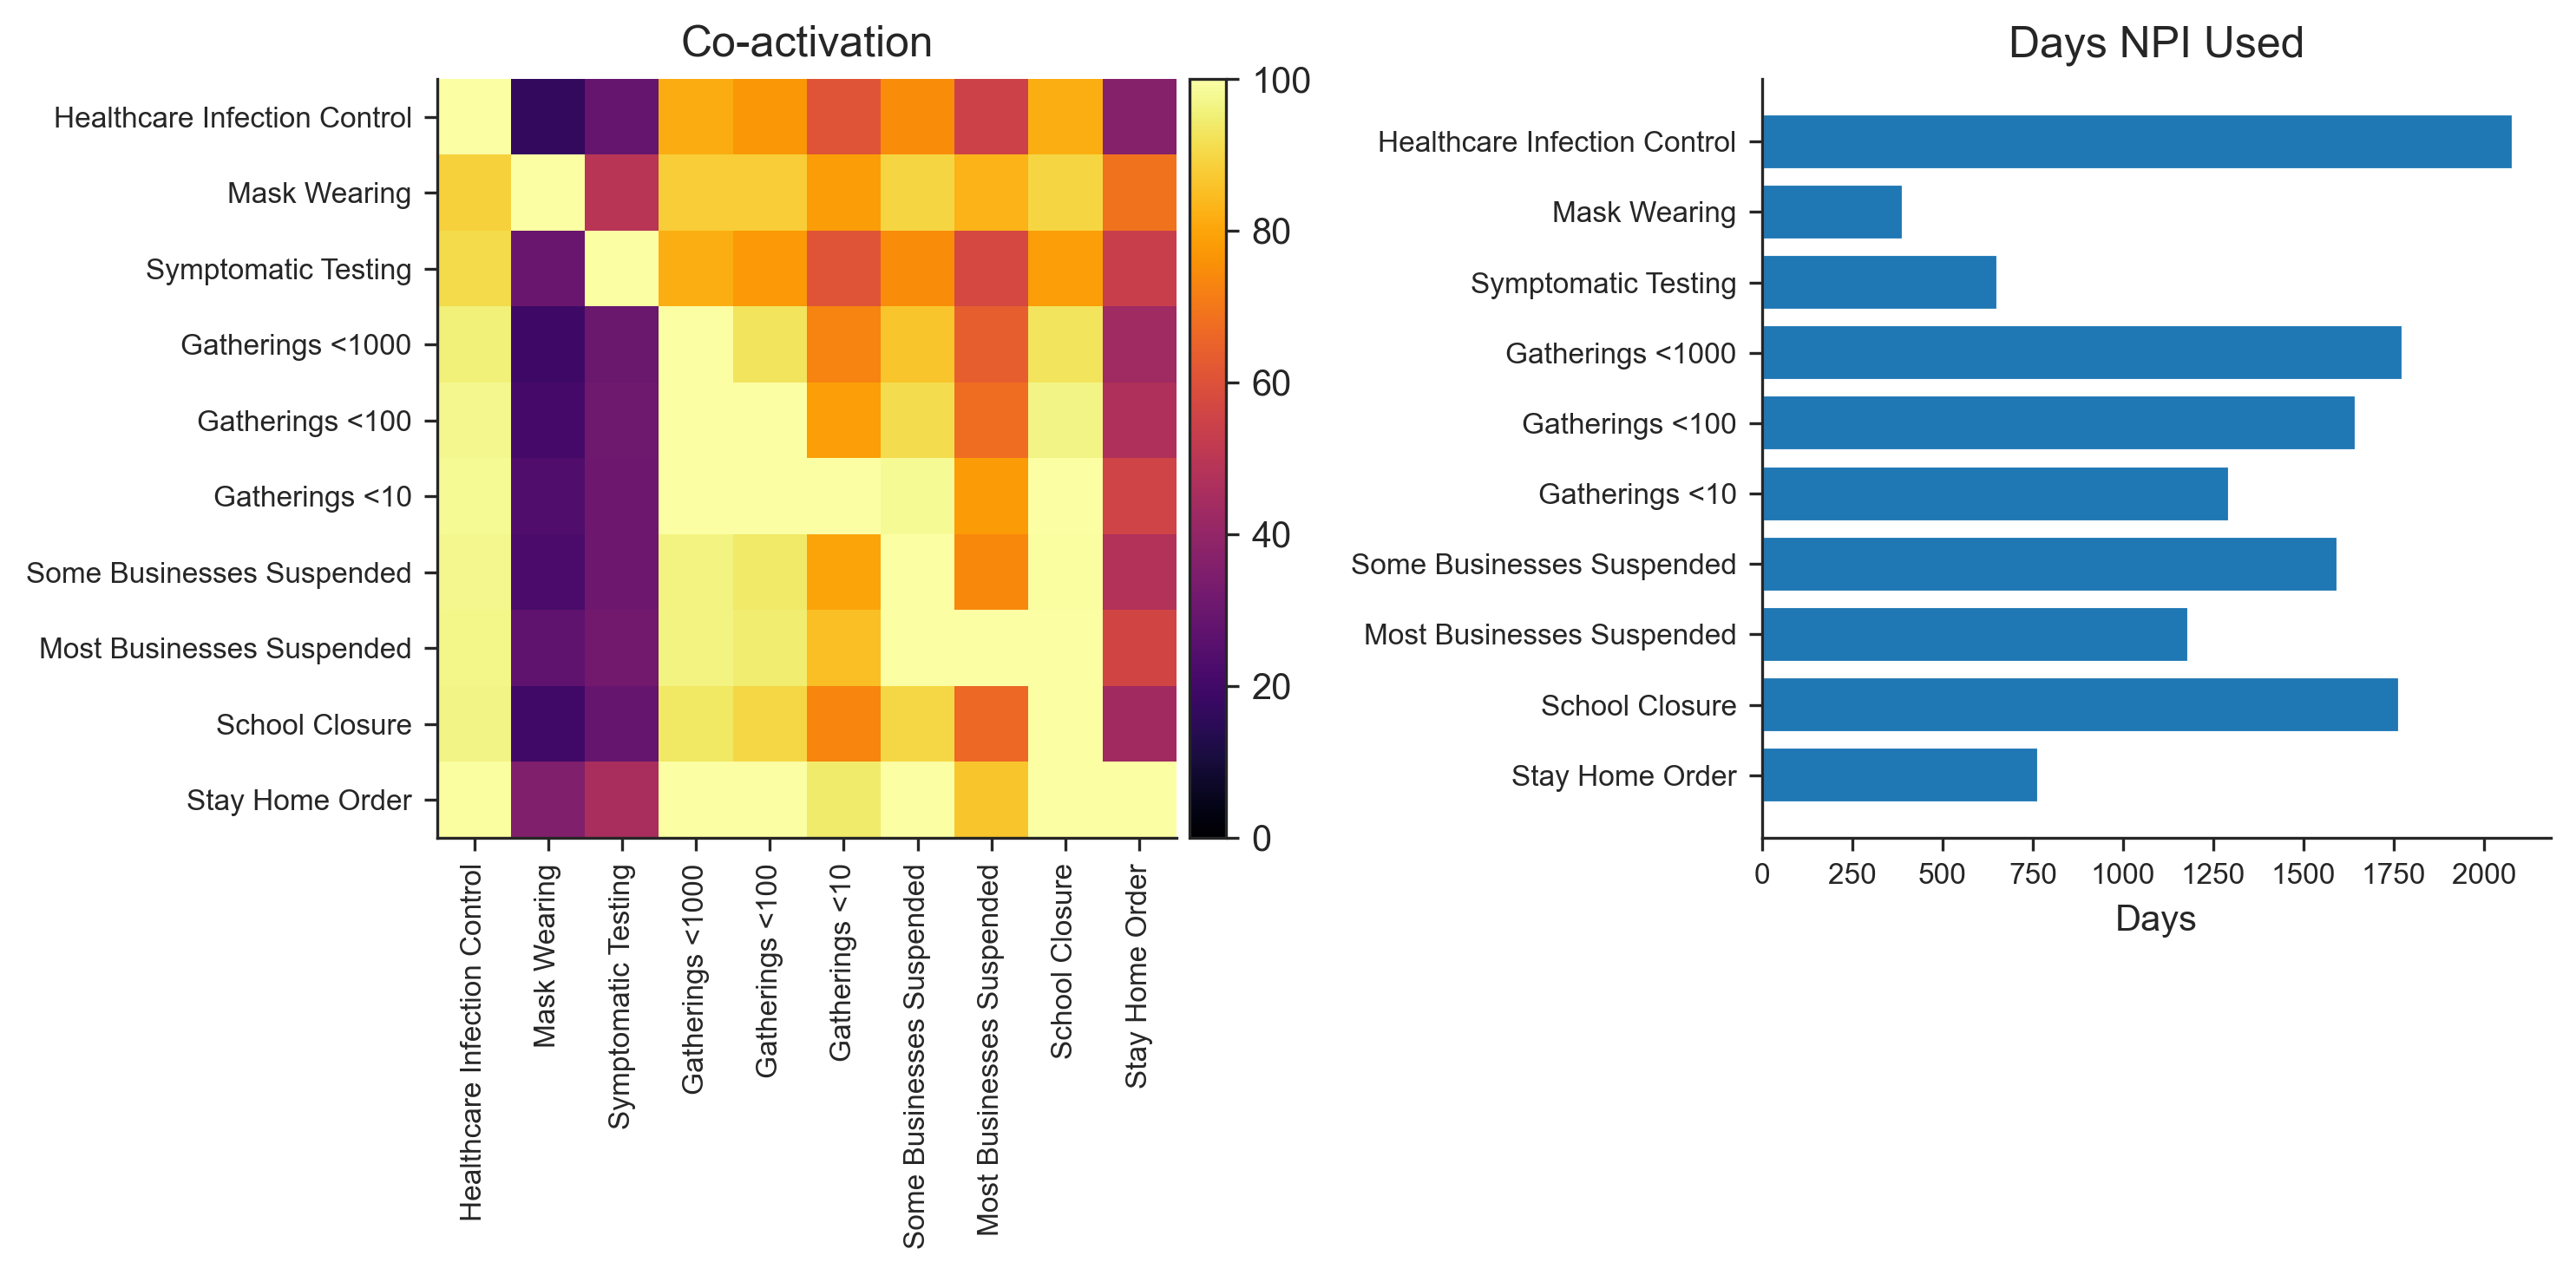

In [28]:
dp = DataPreprocessor(mask_zero_cases=True)
data = dp.preprocess_data("data_final.csv")

In [29]:
data.filter_region_min_deaths(5000)

Region AL removed since it has 27.0 deaths on the last day
Region AD removed since it has 40.0 deaths on the last day
Region AT removed since it has 536.0 deaths on the last day
Region BA removed since it has 57.0 deaths on the last day
Region BG removed since it has 55.0 deaths on the last day
Region HR removed since it has 54.0 deaths on the last day
Region CZ removed since it has 218.0 deaths on the last day
Region DK removed since it has 418.0 deaths on the last day
Region EE removed since it has 46.0 deaths on the last day
Region FI removed since it has 186.0 deaths on the last day
Region GE removed since it has 0.0 deaths on the last day
Region GR removed since it has 130.0 deaths on the last day
Region HU removed since it has 262.0 deaths on the last day
Region IS removed since it has 10.0 deaths on the last day
Region IE removed since it has 1063.0 deaths on the last day
Region IL removed since it has 199.0 deaths on the last day
Region LV removed since it has 12.0 deaths on th

In [30]:
def mask_region_ends(d, region, ndays=10):
    i = d.Rs.index(region)
    d.Active.mask[i,-ndays:] = True
    d.Confirmed.mask[i,-ndays:] = True
    d.Deaths.mask[i,-ndays:] = True
    d.NewDeaths.mask[i,-ndays:] = True
    d.NewCases.mask[i,-ndays:] = True

for region in data.Rs:
    mask_region_ends(data, region, 7)

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedCases contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


11.49997470199402


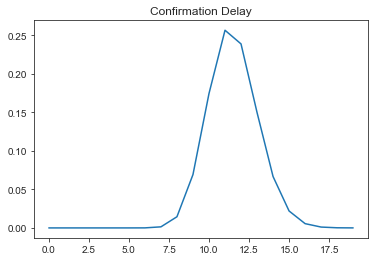

In [31]:
with cm_effect.models.CMActive_R_NewCases_NB(data) as model:
    model.build_model()

plt.figure()
plt.title("Confirmation Delay")
plt.plot(model.DelayProb)
print(np.sum([i * model.DelayProb[i] for i in range(len(model.DelayProb))]))

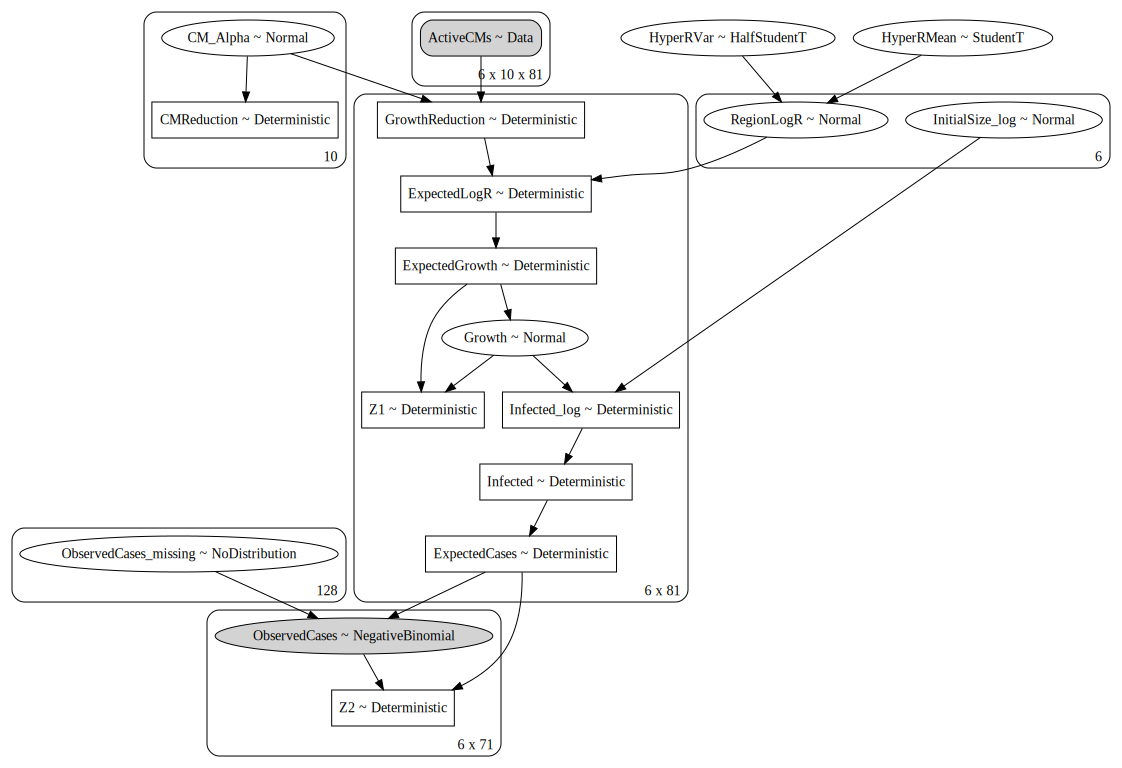

In [32]:
pm.model_to_graphviz(model).render("model-active-newcases")
pm.model_to_graphviz(model)

In [33]:
with model.model:
    model.trace = pm.sample(2000, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
INFO:pymc3:>NUTS: [InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
>Metropolis: [ObservedCases_missing]
INFO:pymc3:>Metropolis: [ObservedCases_missing]
Sampling 2 chains, 312 divergences: 100%|██████████| 5000/5000 [02:30<00:00, 33.29draws/s] 
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out


<Figure size 2100x900 with 0 Axes>

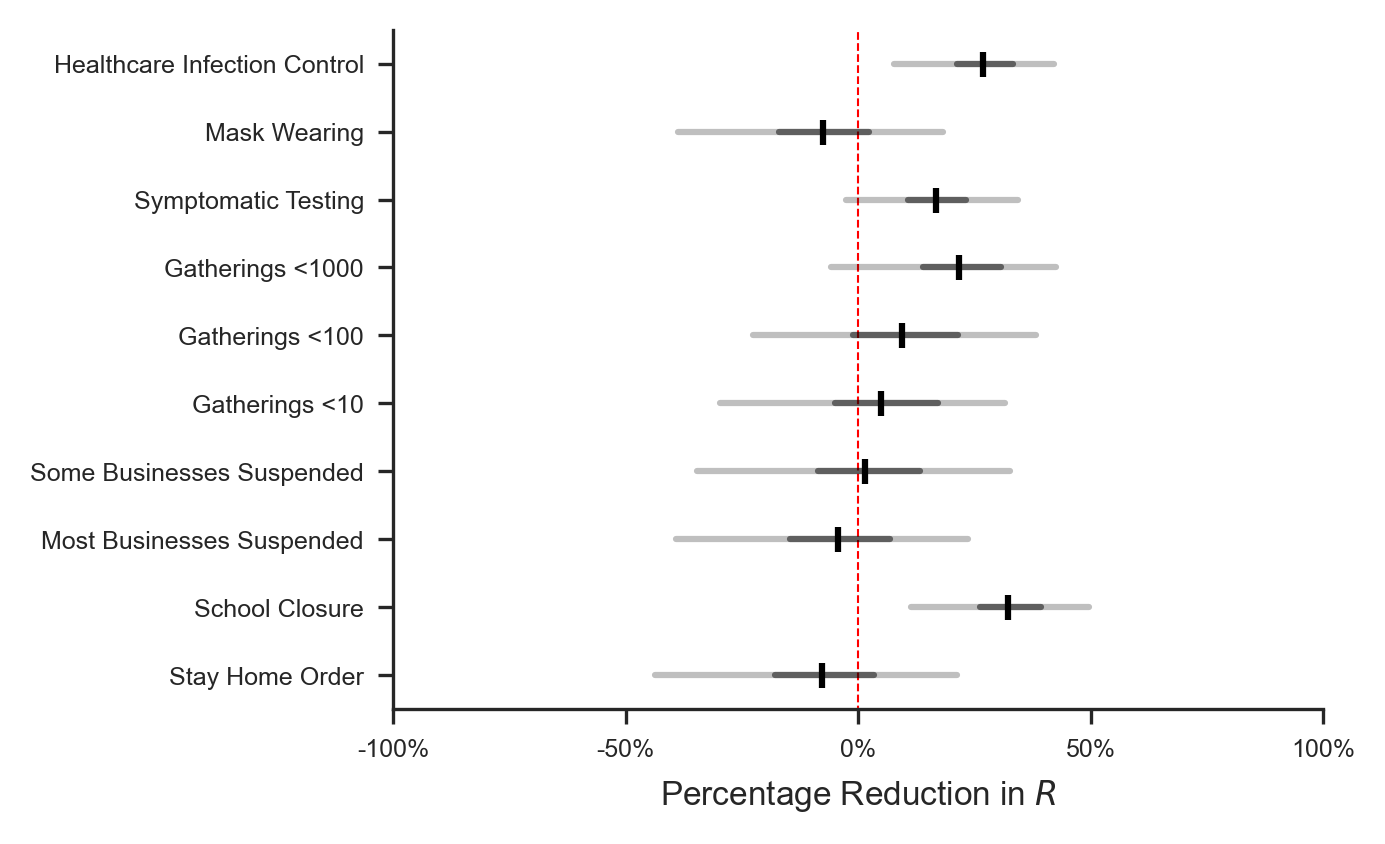

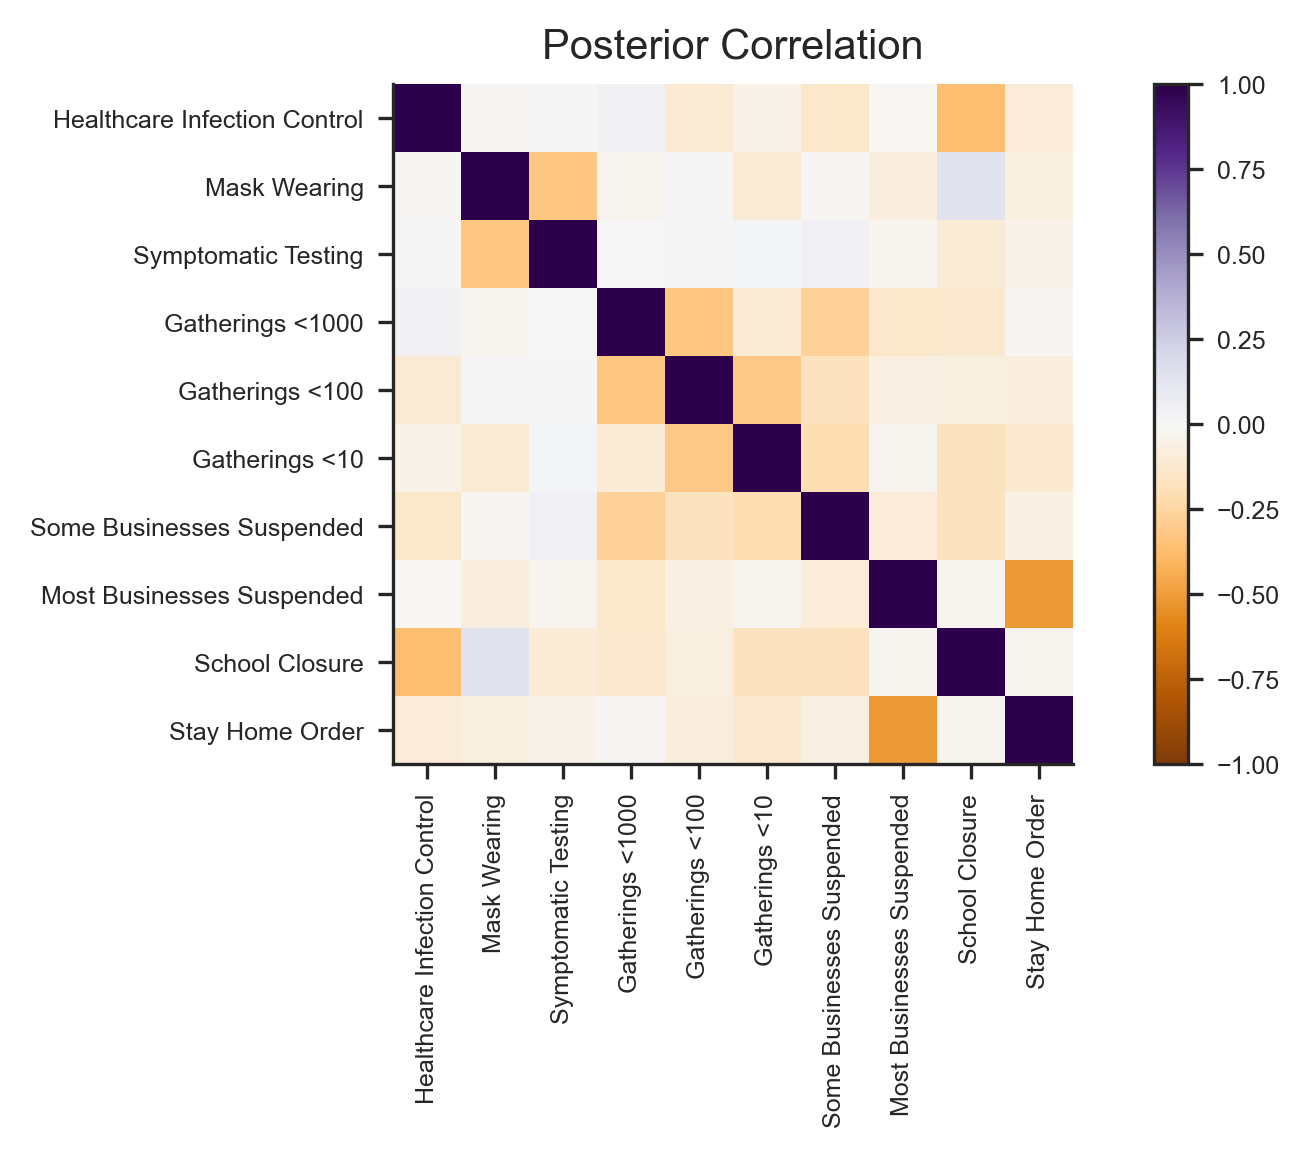

In [36]:
model.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out


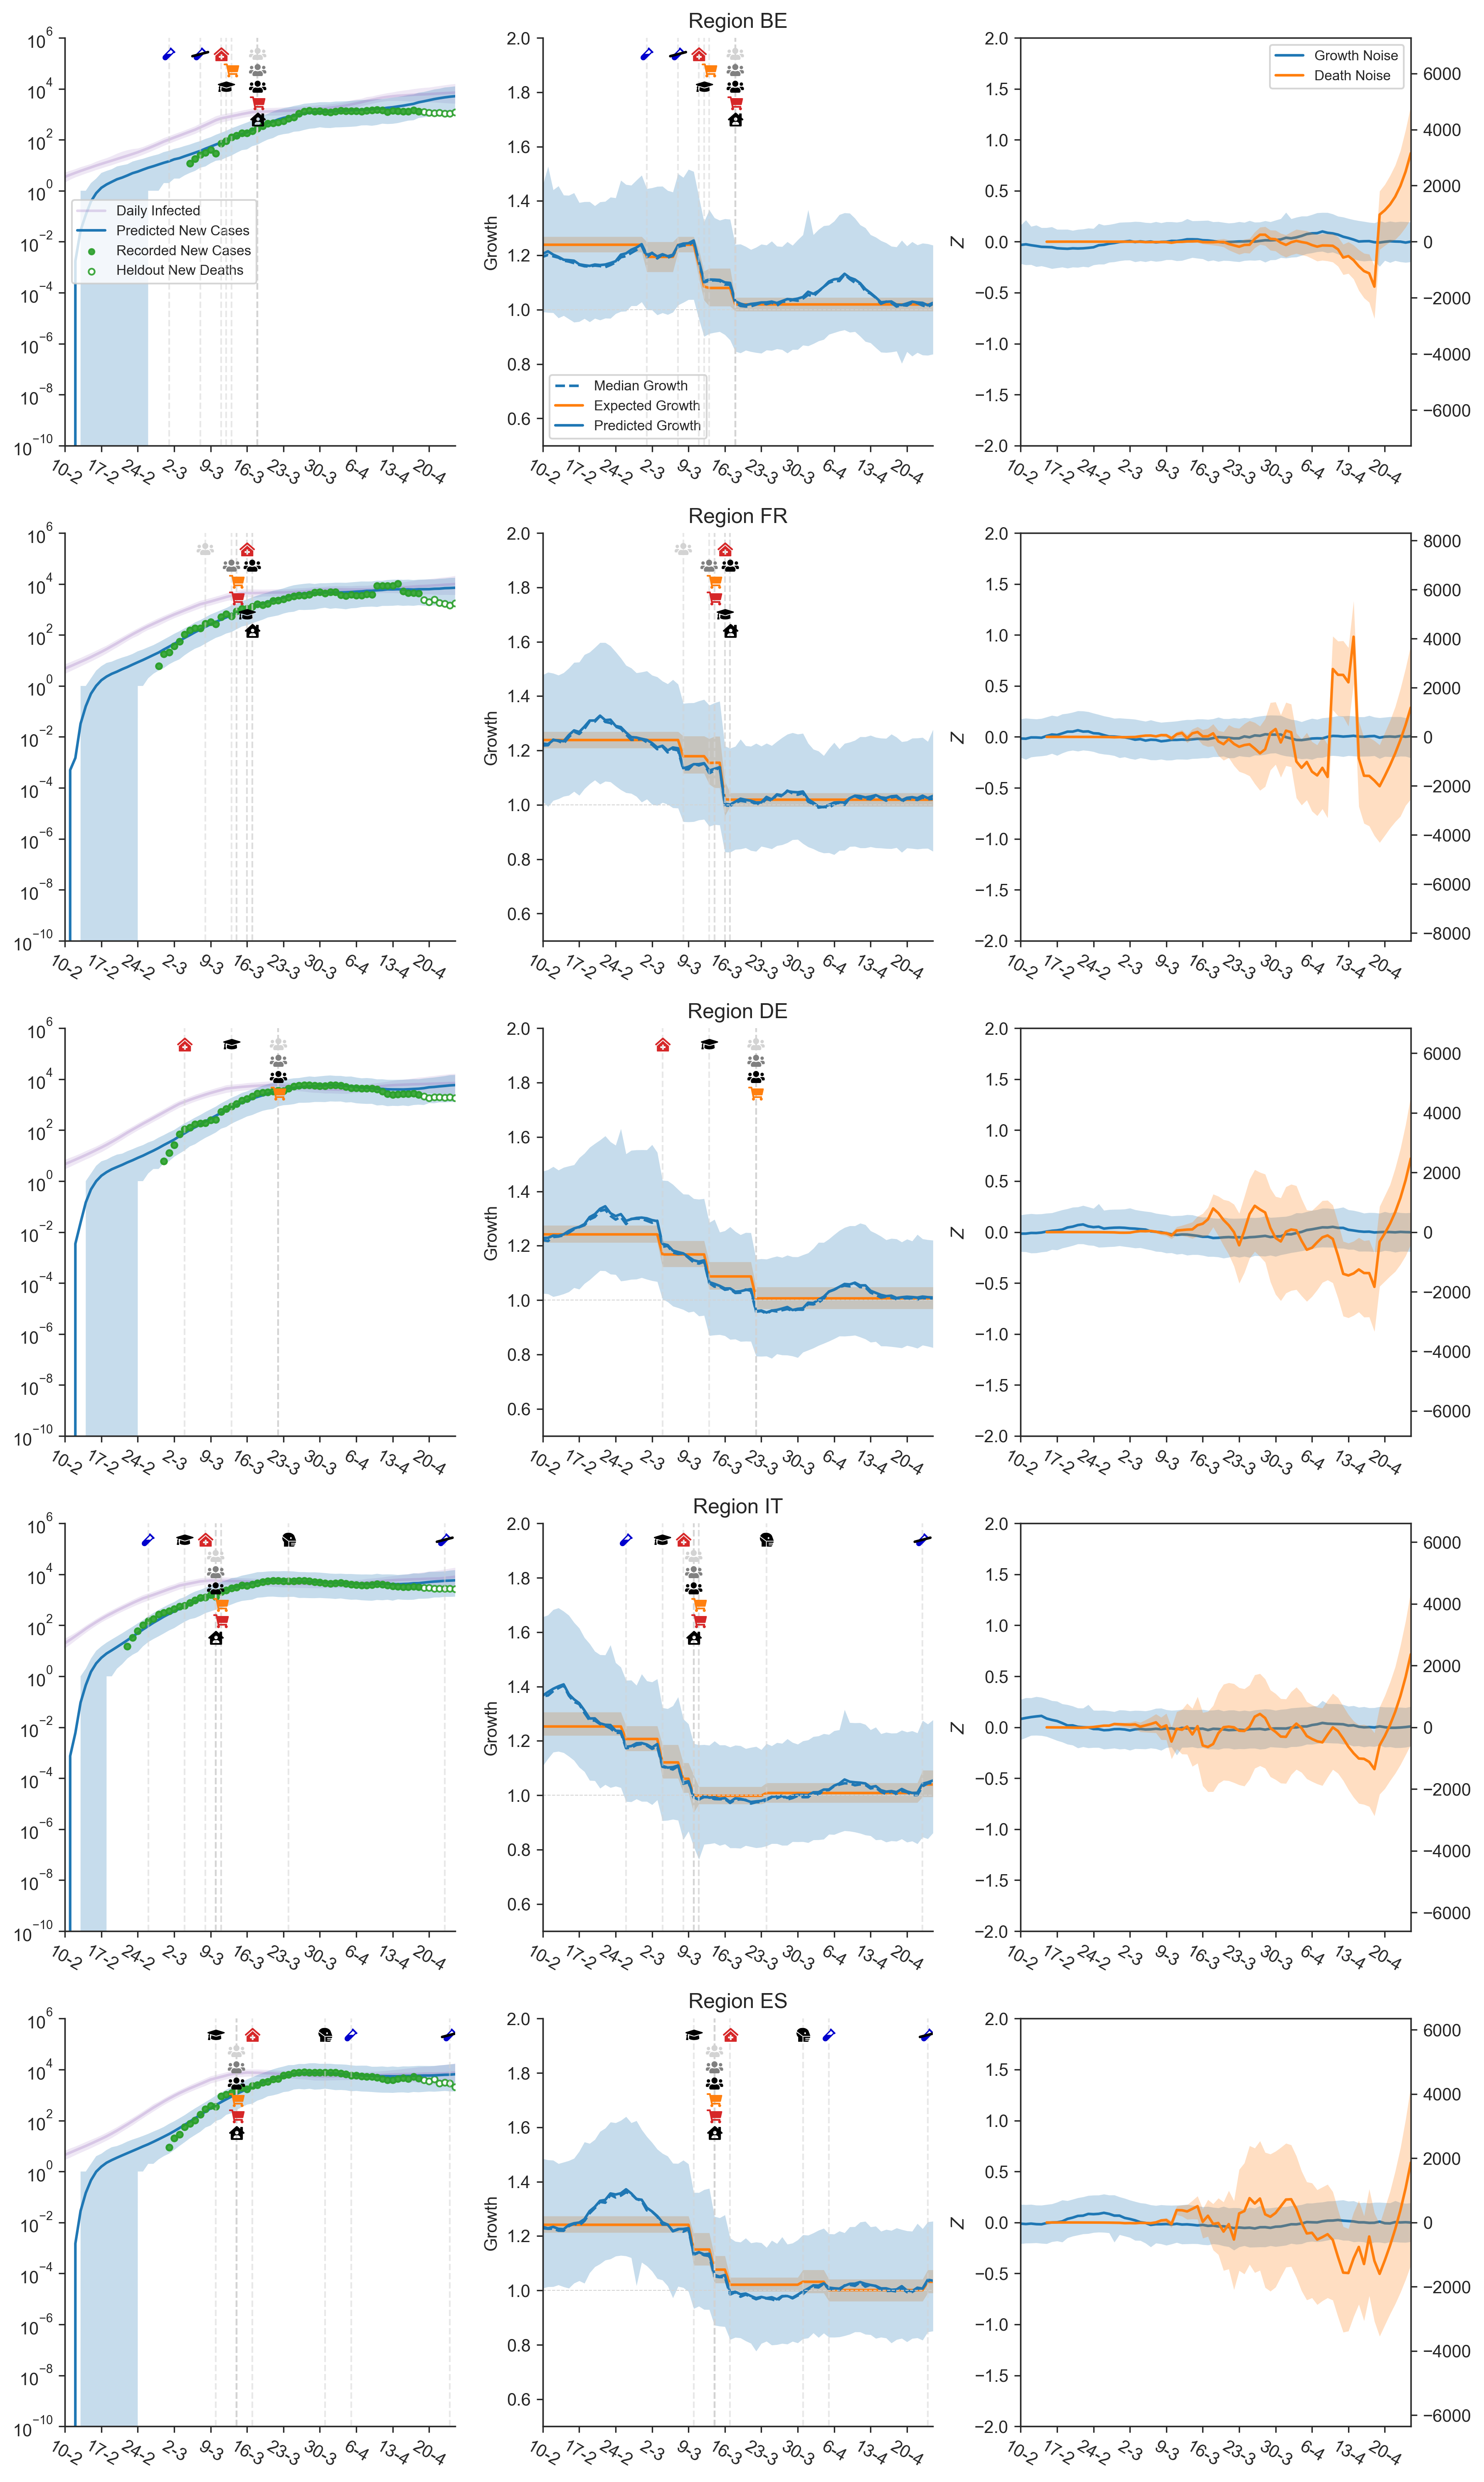

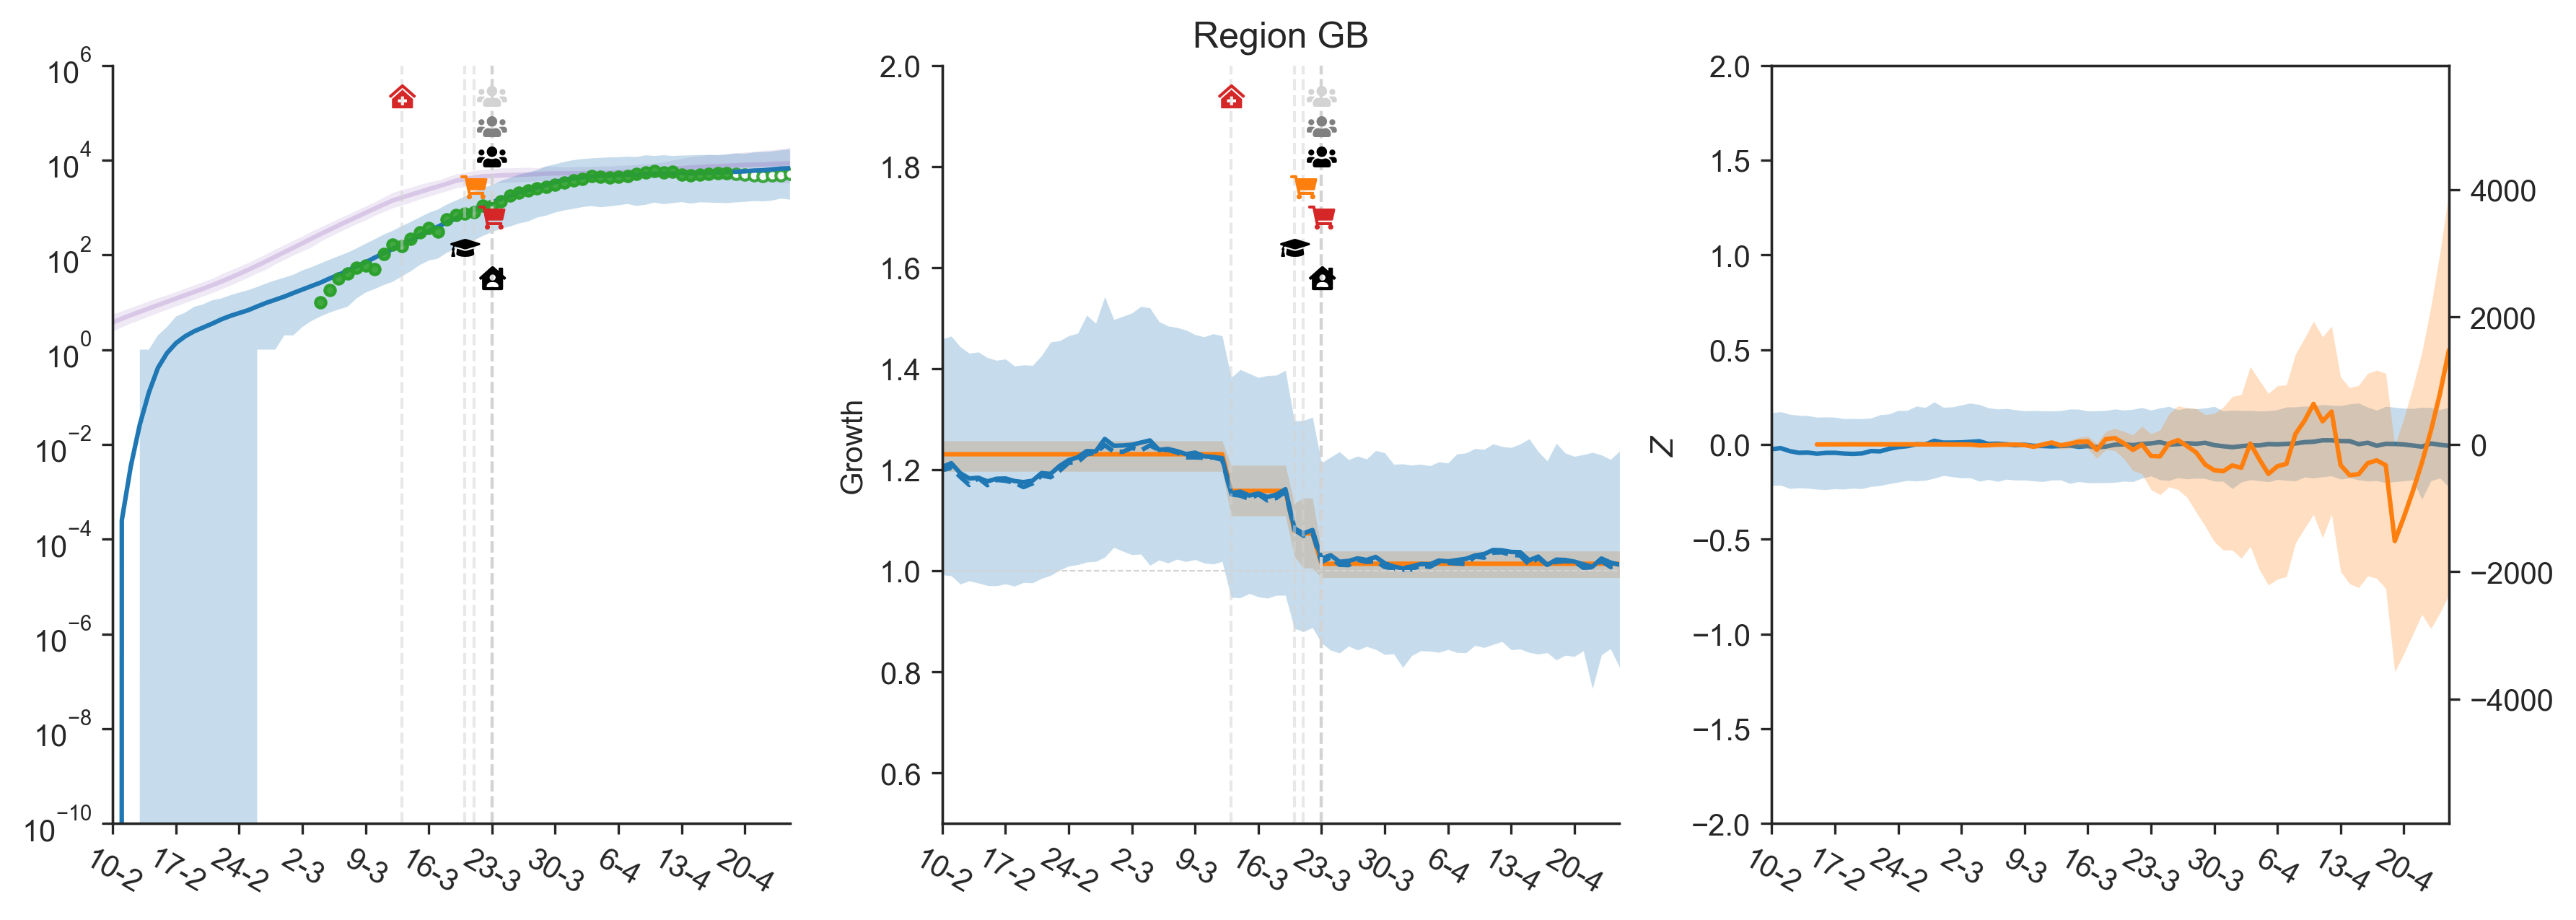

In [55]:
cm_plot_style = [
            ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf492", "mediumblue"), # vial
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2 
            ("\uf19d", "black"), # school
            ("\uf965", "black") # home
        ]

model.plot_region_predictions(cm_plot_style)

fucking hell, this is shocking ...

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


Region AL removed since it has 27.0 deaths on the last day
Region AD removed since it has 40.0 deaths on the last day
Region AT removed since it has 536.0 deaths on the last day
Region BA removed since it has 57.0 deaths on the last day
Region BG removed since it has 55.0 deaths on the last day
Region HR removed since it has 54.0 deaths on the last day
Region CZ removed since it has 218.0 deaths on the last day
Region DK removed since it has 418.0 deaths on the last day
Region EE removed since it has 46.0 deaths on the last day
Region FI removed since it has 186.0 deaths on the last day
Region GE removed since it has 0.0 deaths on the last day
Region GR removed since it has 130.0 deaths on the last day
Region HU removed since it has 262.0 deaths on the last day
Region IS removed since it has 10.0 deaths on the last day
Region IE removed since it has 1063.0 deaths on the last day
Region IL removed since it has 199.0 deaths on the last day
Region LV removed since it has 12.0 deaths on th

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedCases contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


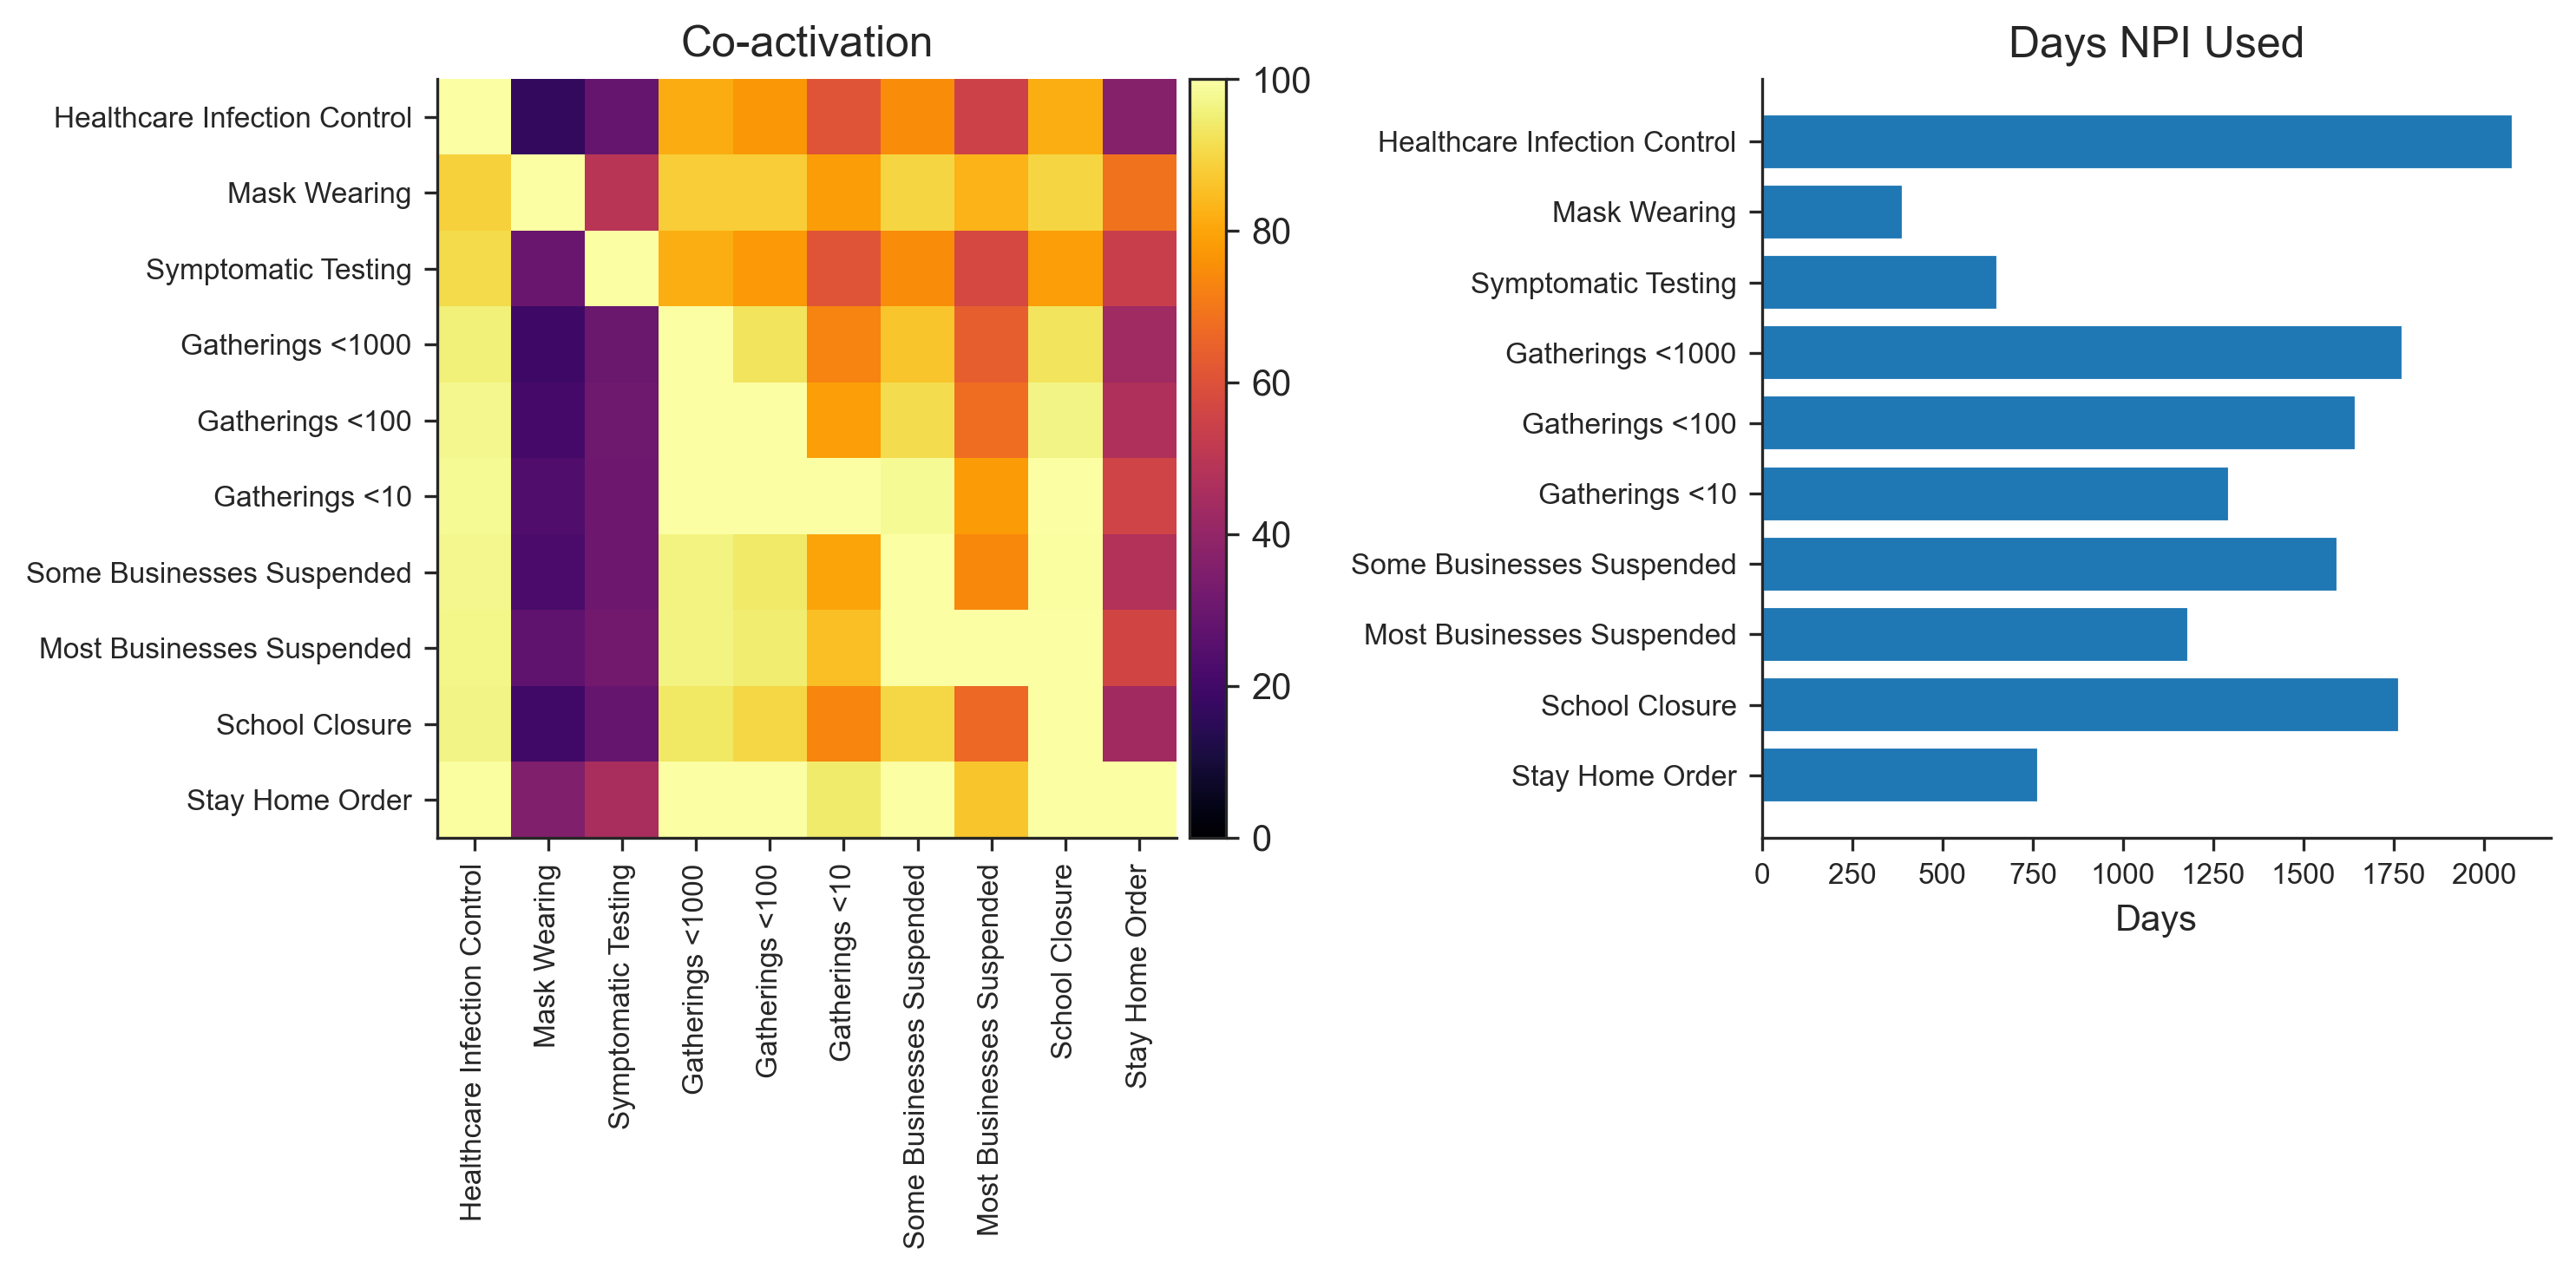

In [51]:
dp = DataPreprocessor()
data = dp.preprocess_data("data_final.csv")

def mask_region_ends(d, region, ndays=10):
    i = d.Rs.index(region)
    d.Active.mask[i,-ndays:] = True
    d.Confirmed.mask[i,-ndays:] = True
    d.Deaths.mask[i,-ndays:] = True
    d.NewDeaths.mask[i,-ndays:] = True
    d.NewCases.mask[i,-ndays:] = True

data.filter_region_min_deaths(5000)    

for region in data.Rs:
    mask_region_ends(data, region, 7)
    
with cm_effect.models.CMActive_R_NewCases_NB(data) as model2:
    model2.build_model()

In [52]:
with model2:
    model2.trace = pm.sample(2000, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
INFO:pymc3:>NUTS: [InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
>Metropolis: [ObservedCases_missing]
INFO:pymc3:>Metropolis: [ObservedCases_missing]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:07<00:00, 20.19draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/final_data/out


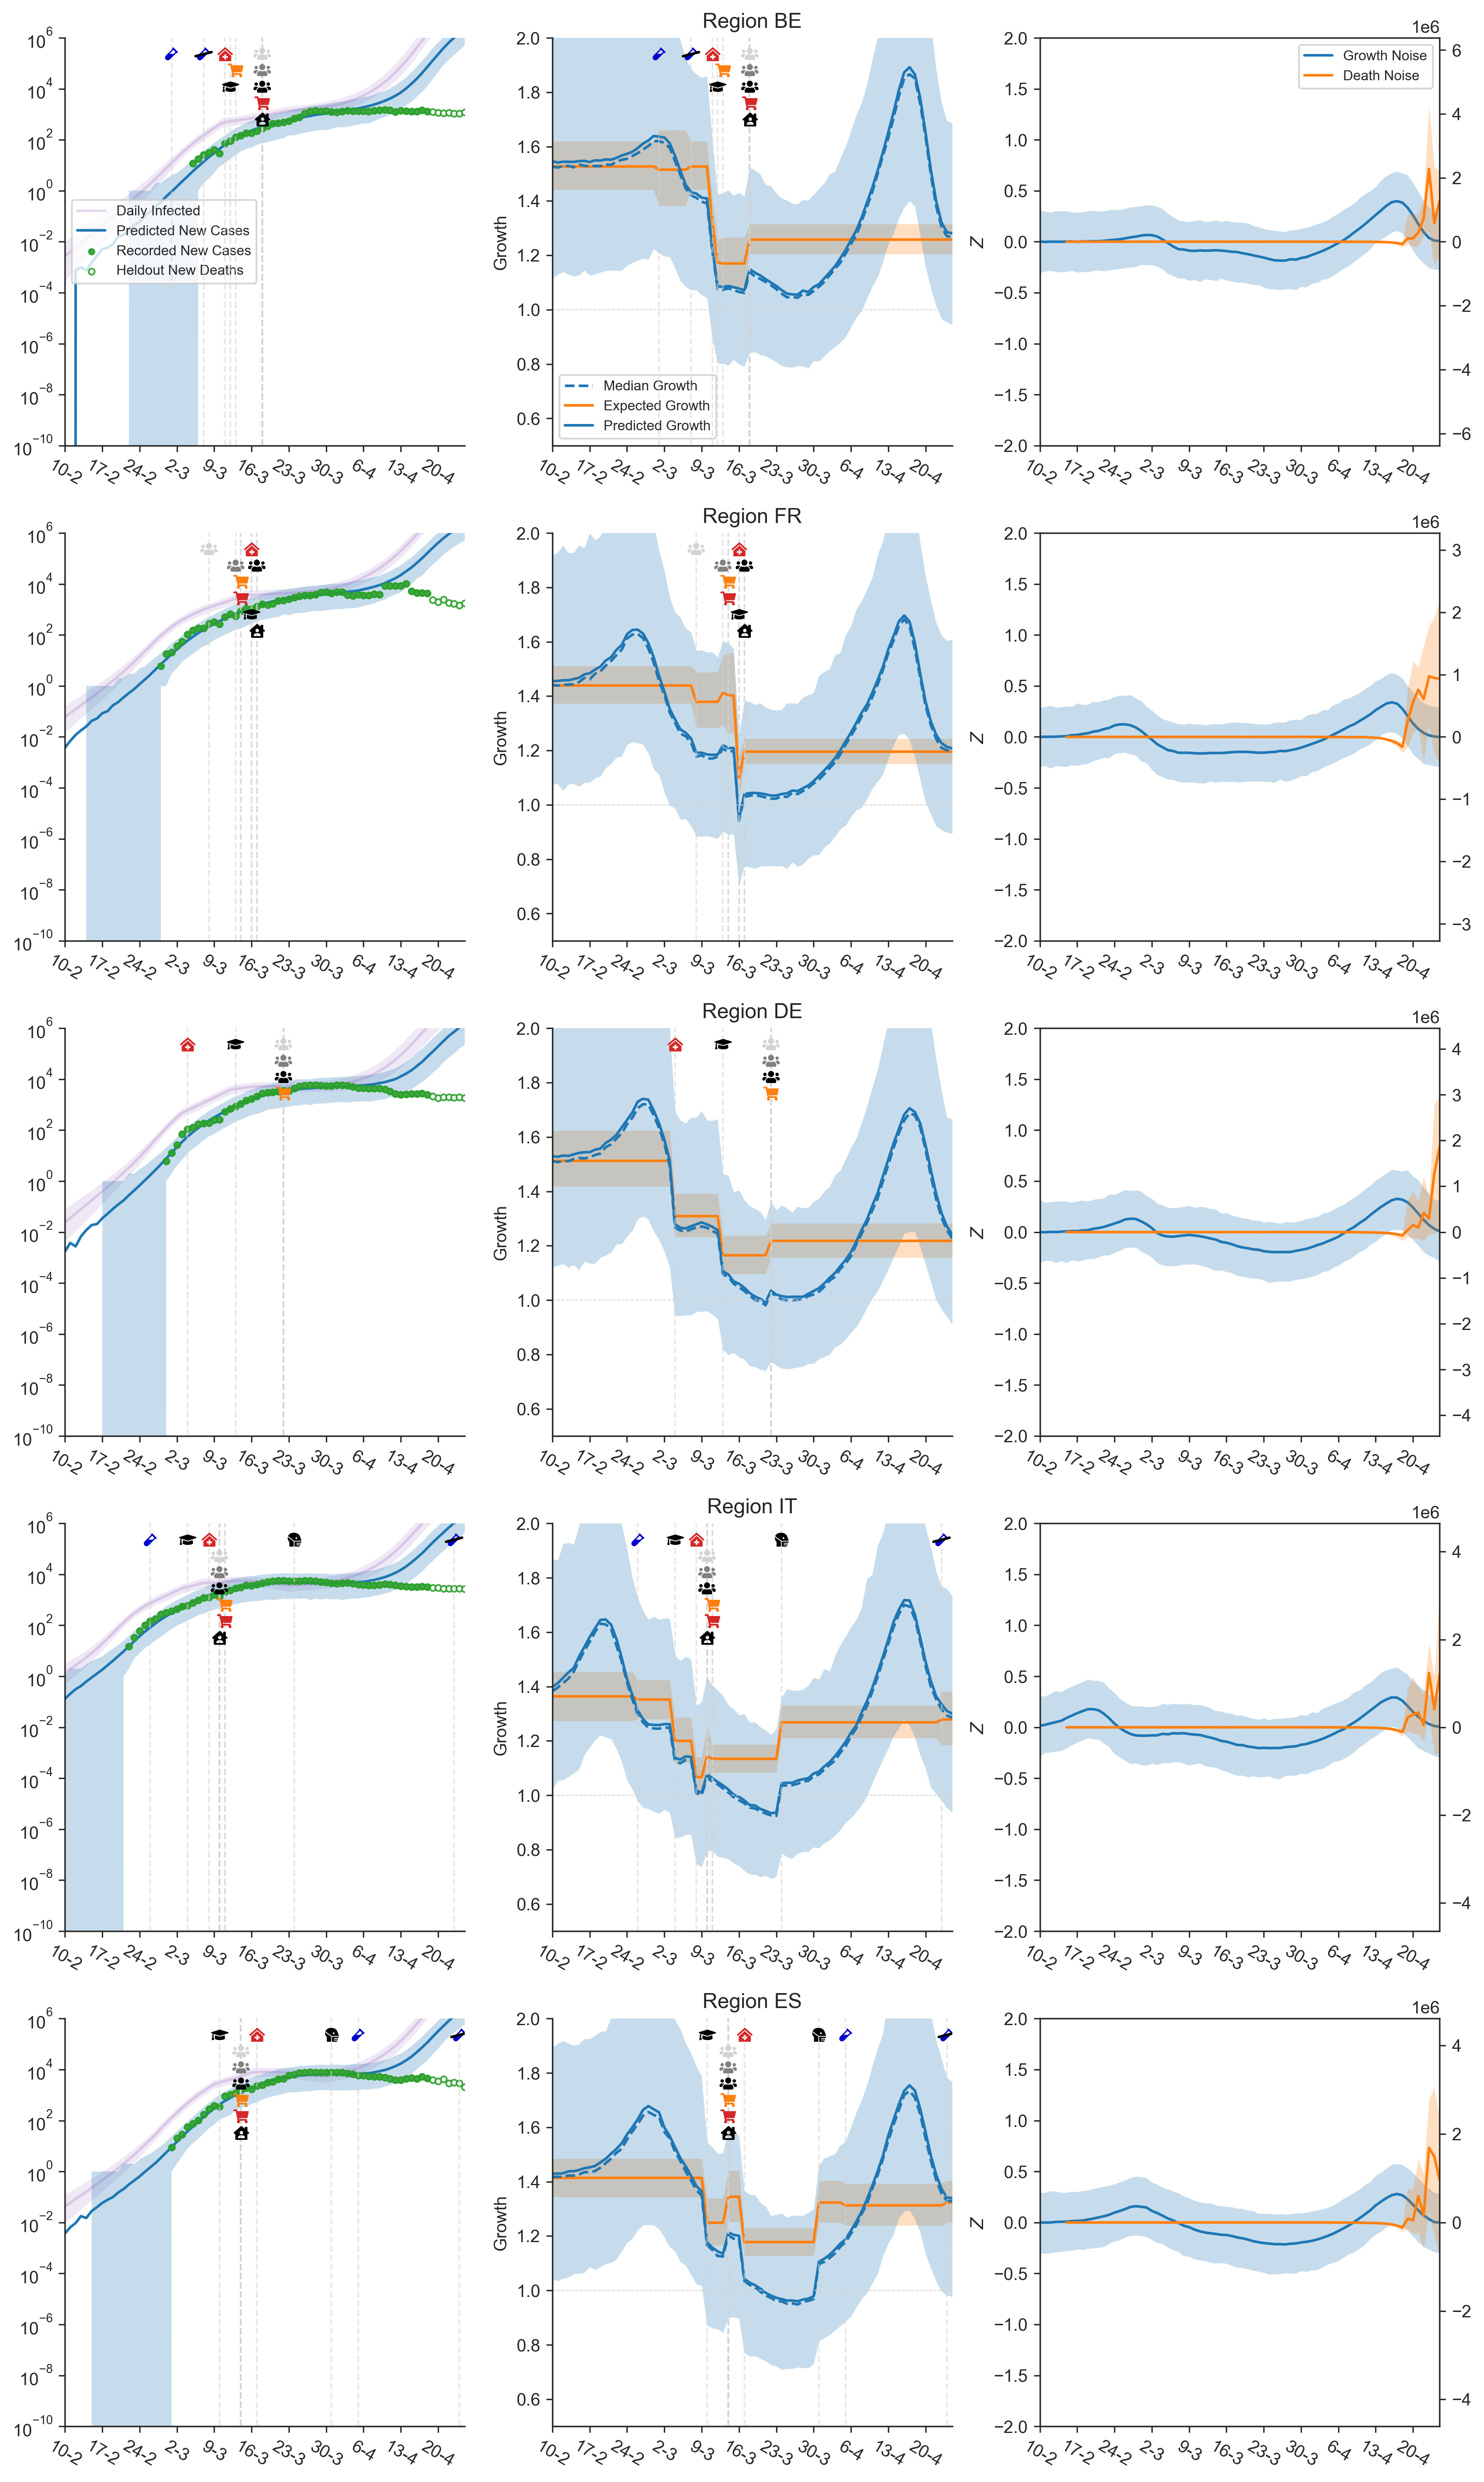

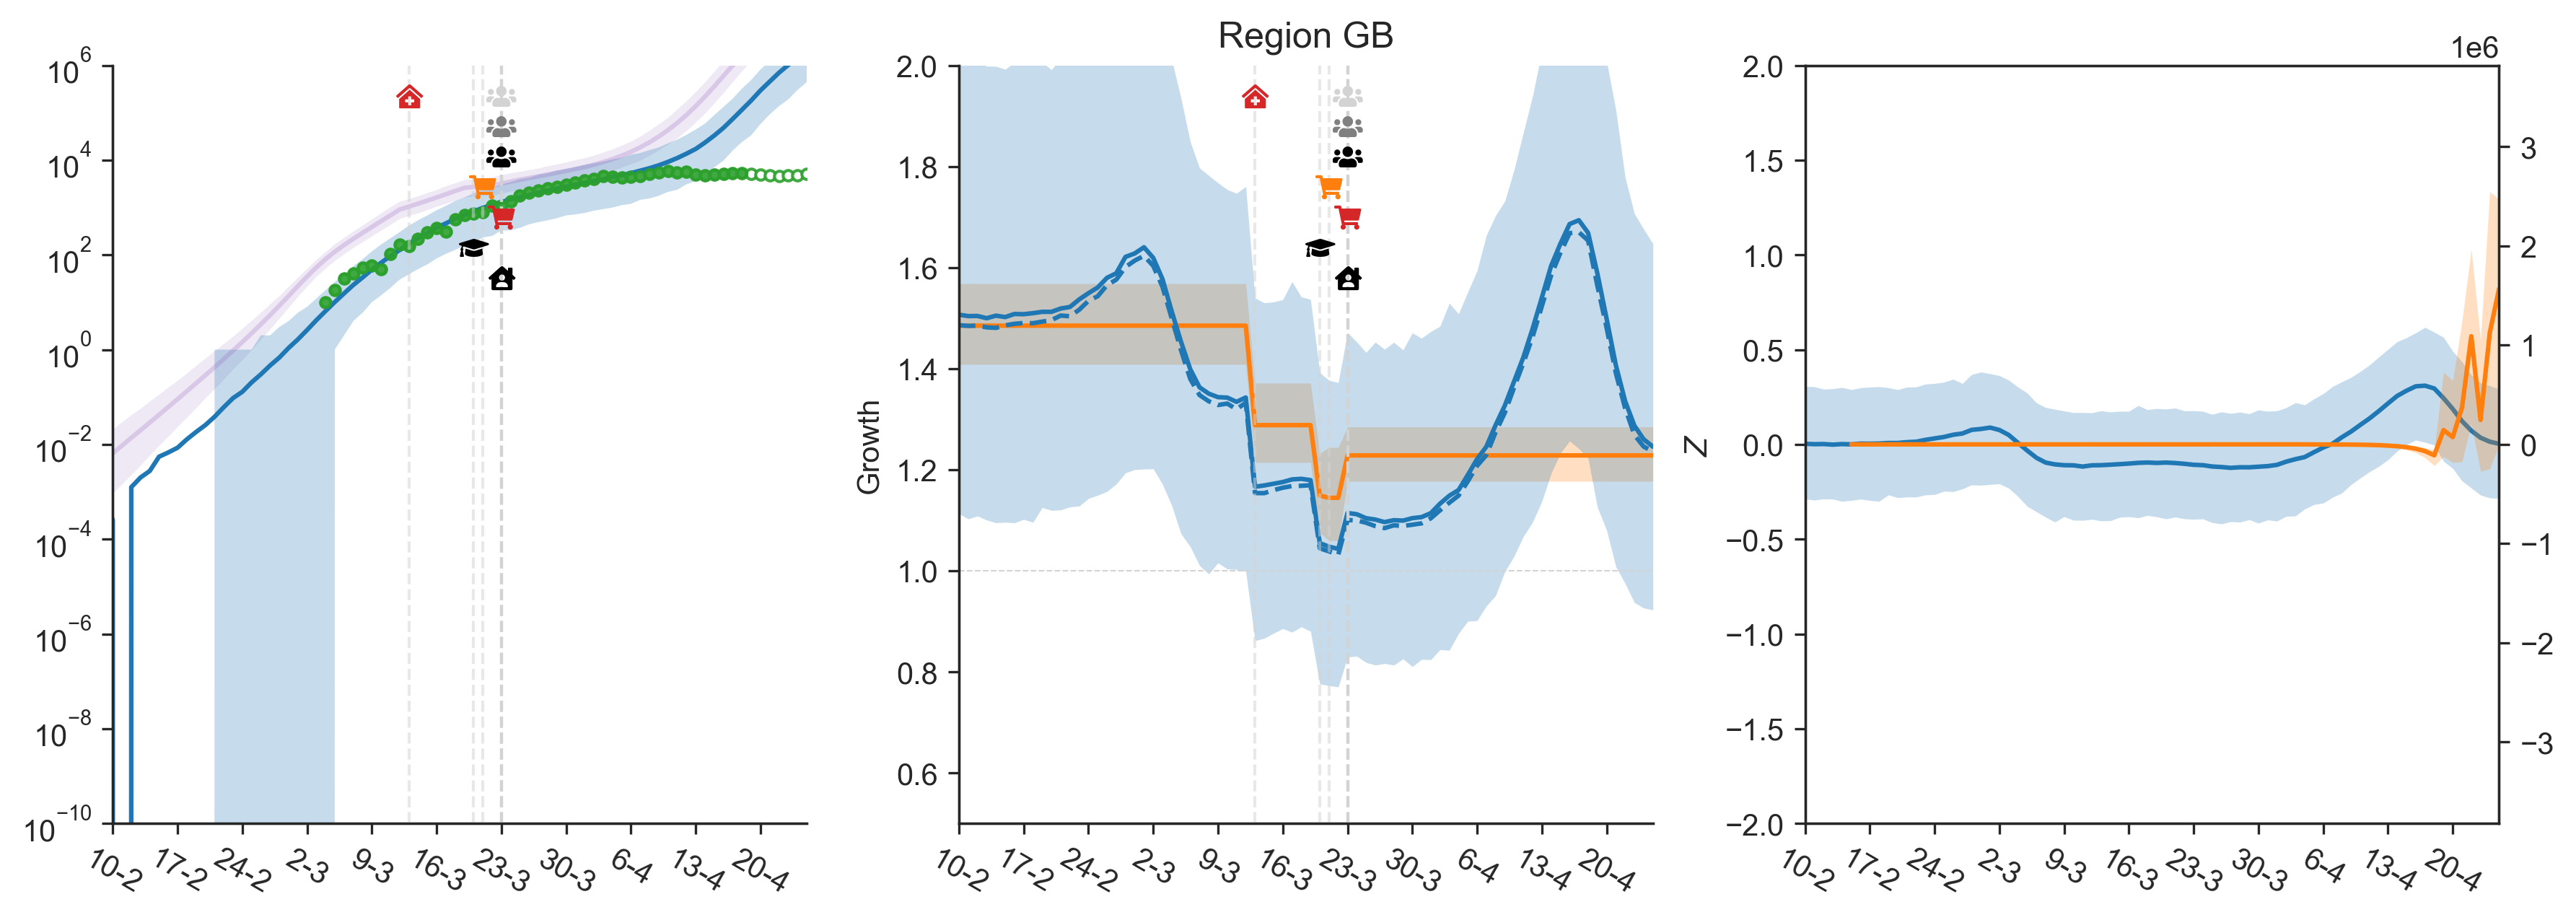

In [56]:
model2.plot_region_predictions(cm_plot_style)